## Initial configuration

### Importing required packages

In [1]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, History, ReduceLROnPlateau
from keras.regularizers import l1
from keras.applications import VGG16, InceptionV3

Using TensorFlow backend.


In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import xgboost
from joblib import dump, load

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from langdetect import detect

import seaborn as sns
import altair as alt
import warnings

### Configuring packages

In [3]:
sns.set_style('white')

alt.themes.enable('default')
alt.renderers.enable('kaggle')
alt.renderers.set_embed_options(actions=False)
alt.data_transformers.enable('json')
warnings.filterwarnings("ignore", 'This pattern has match groups')

In [215]:
try:
    nltk.download('vader_lexicon')
except:
    pass

try:
    nltk.download('stopwords')
except:
    pass

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading

### Setting dataset location 

In [5]:
DATA_PATH = Path(r'C:\Users\Thomas\Desktop\PSI\AirbnbPrediction\input\airbnb')

### Loading data

In [7]:
listings_df = pd.read_csv(DATA_PATH/'listings_summary.csv')
listings_detail_df = pd.read_csv(DATA_PATH/'listings.csv')

reviews_df = pd.read_csv(DATA_PATH/'reviews_summary.csv')
reviews_detail_df = pd.read_csv(DATA_PATH/'reviews.csv')

calendar_df = pd.read_csv(DATA_PATH/'calendar.csv')

neighborhood_df = pd.read_csv(DATA_PATH/'neighbourhoods.csv')
gdf = gpd.read_file(DATA_PATH/'neighbourhoods.geojson')

## Data Exploration

### listings_summary

#### Data overview

In [8]:
print(f'Number of rows: {listings_df.shape[0]}\nNumber of cols: {listings_df.shape[1]}')
listings_df.sample(3)

Number of rows: 85068
Number of cols: 16


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
76739,37933837,Elegant 1 Bed Apt w/Balcony nr South Kensington,285567629,Rasa,NaN,Kensington and Chelsea,51.48714,-0.16820,Entire home/apt,92,2,5,2019-10-17,2.50,1,244
7003,5484446,See Paris from Covent Garden! ;),25252772,Johnny,NaN,Camden,51.51519,-0.12729,Entire home/apt,155,6,82,2019-08-20,1.48,2,306
55520,29774702,Modern & Bright ★2 Bed/2 Bath Flat★ in East Lo...,33851135,Rebecca,NaN,Hackney,51.53384,-0.07429,Entire home/apt,100,2,8,2019-10-25,1.00,2,14


#### Displaying number of nullable records

In [9]:
listings_df.loc[:, listings_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

neighbourhood_group    85068
reviews_per_month      20006
last_review            20006
name                      25
host_name                 12
dtype: int64

#### Displaying number of records without variance (having same value)

In [10]:
listings_df.loc[:, listings_df.nunique() <= 1].nunique().sort_values()

neighbourhood_group    0
dtype: int64

#### Plotting neighbourhood values into chart

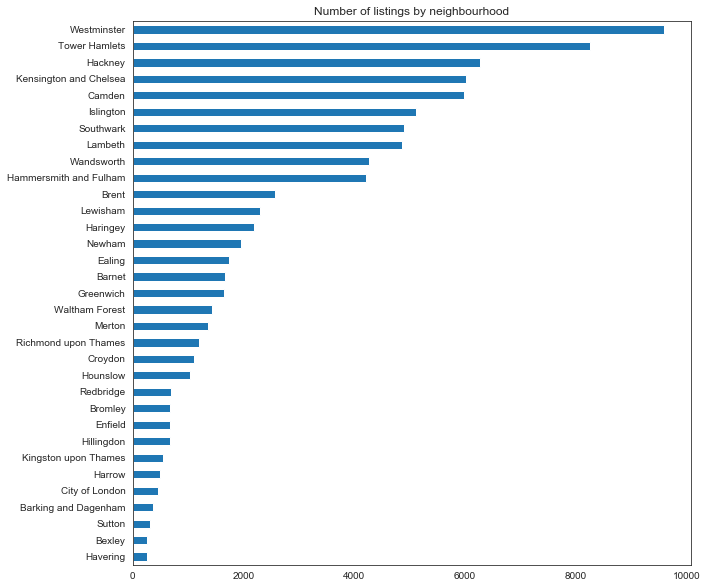

In [11]:
listings_df['neighbourhood'].value_counts().sort_values().plot.barh(figsize=(10, 10));
plt.title('Number of listings by neighbourhood');

#### Plotting room_type values into chart

Text(0.5, 1.0, 'Number of listings by room type')

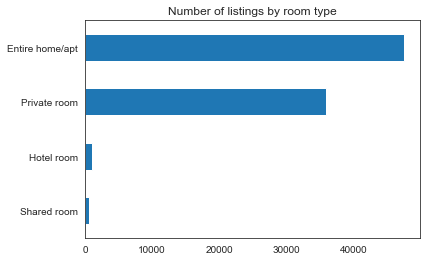

In [12]:
listings_df['room_type'].value_counts().sort_values().plot.barh()
plt.title('Number of listings by room type')

### listings

#### Data overview

In [13]:
print(f'Number of rows: {listings_detail_df.shape[0]}\nNumber of cols: {listings_detail_df.shape[1]}')
listings_detail_df.sample(3)

Number of rows: 85068
Number of cols: 106


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
83682,39594852,https://www.airbnb.com/rooms/39594852,20191105115249,2019-11-06,Private room in a Hostel,Hotel room,NaN,Hotel room,none,NaN,...,f,f,flexible,f,f,4,0,4,0,NaN
9534,7192421,https://www.airbnb.com/rooms/7192421,20191105115249,2019-11-06,"Sunny, private studio -- own entrance & courtyard","This quiet, bright and airy studio for a maxim...",ROOM FOR TWO: This is a calm and airy space --...,"This quiet, bright and airy studio for a maxim...",none,"Teddington is a safe, green and serene part of...",...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.39
27595,17886306,https://www.airbnb.com/rooms/17886306,20191105115249,2019-11-05,Palm Tree & Pineapple House E17,East London palm tree & pineapple haven. A 19...,Tropical lounge - relax on the comfy sofa or a...,East London palm tree & pineapple haven. A 19...,none,Walthamstow is perfectly located as a base for...,...,f,f,flexible,f,f,1,1,0,0,0.27


#### Displaying number of nullable records

In [14]:
listings_detail_df.loc[:, listings_detail_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

medium_url                      85068
xl_picture_url                  85068
neighbourhood_group_cleansed    85068
host_acceptance_rate            85068
thumbnail_url                   85068
jurisdiction_names              85066
license                         84889
square_feet                     84671
monthly_price                   80103
weekly_price                    78112
notes                           52269
access                          39320
house_rules                     35807
host_about                      35751
interaction                     35286
transit                         30748
neighborhood_overview           30374
security_deposit                29125
host_response_rate              25900
host_response_time              25900
space                           25850
review_scores_checkin           21723
review_scores_value             21722
review_scores_location          21721
review_scores_accuracy          21675
review_scores_communication     21667
review_score

#### Displaying number of records without variance (having same value)

In [15]:
listings_detail_df.loc[:, listings_detail_df.nunique() <= 1].nunique().sort_values()

thumbnail_url                   0
medium_url                      0
xl_picture_url                  0
host_acceptance_rate            0
neighbourhood_group_cleansed    0
scrape_id                       1
has_availability                1
jurisdiction_names              1
is_business_travel_ready        1
dtype: int64

#### Couting number of rows with missing review score (there are 7 columns containing reviews score for different scopes)

In [16]:
listings_detail_df.filter(regex='review_scores').isnull().sum(axis=1).value_counts()

0    63317
7    21616
3       40
4       34
1       23
6       22
5       12
2        4
dtype: int64

### calendar

#### Data overview

In [17]:
print(f'Number of rows: {calendar_df.shape[0]}\nNumber of cols: {calendar_df.shape[1]}')
calendar_df.sample(3)

Number of rows: 31050094
Number of cols: 7


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
6118574,12003274,2020-03-19,f,$172.00,$172.00,1.0,1.0
29664152,39045265,2019-11-21,f,$200.00,$200.00,3.0,1125.0
1604733,3357447,2020-05-19,f,$95.00,$95.00,3.0,90.0


#### Displaying number of nullable records

In [18]:
calendar_df.loc[:, calendar_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

adjusted_price    918
price             918
maximum_nights     10
minimum_nights     10
dtype: int64

### reviews

#### Data overview

In [19]:
print(f'Number of rows: {reviews_df.shape[0]}\nNumber of cols: {reviews_df.shape[1]}')
reviews_df.sample(3)

Number of rows: 1486236
Number of cols: 2


,listing_id,date
1301831,28492377,2018-09-22
236059,3218111,2014-07-20
672888,13934353,2017-03-05


#### Displaying number of nullable records

In [20]:
reviews_df.isnull().sum()

listing_id    0
date          0
dtype: int64

### reviews_summary

#### Data oveview

In [21]:
print(f'Number of rows: {reviews_detail_df.shape[0]}\nNumber of cols: {reviews_detail_df.shape[1]}')
reviews_detail_df.sample(3)

Number of rows: 1486236
Number of cols: 6


,listing_id,id,date,reviewer_id,reviewer_name,comments
449296,7952542,283111667,2018-06-29,34880083,Lucy,We really liked the flat. Great location and l...
1364369,31246945,460466960,2019-05-29,46934967,Ashaka,The apartment and stay was beyond our expectat...
79299,554694,71319959,2016-04-24,58685394,Aurélie,"Un voyage inoubliable, Gerry est un super hôte..."


#### Displaying number of nullable records

In [22]:
reviews_detail_df.loc[:, reviews_detail_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

comments    622
dtype: int64

### neighbourhoods

#### Data overview

In [23]:
print(f'Number of rows: {neighborhood_df.shape[0]}\nNumber of cols: {neighborhood_df.shape[1]}')
neighborhood_df.sample(3)

Number of rows: 33
Number of cols: 2


,neighbourhood_group,neighbourhood
12,NaN,Hammersmith and Fulham
31,NaN,Wandsworth
20,NaN,Kingston upon Thames


#### Displaying number of nullable records

In [24]:
neighborhood_df.loc[:, neighborhood_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

neighbourhood_group    33
dtype: int64

### neighbourhoods.geojson

#### Data overview

In [25]:
print(f'Number of rows: {gdf.shape[0]}\nNumber of cols: {gdf.shape[1]}')
gdf.sample(3)

Number of rows: 33
Number of cols: 3


,neighbourhood,neighbourhood_group,geometry
4,Ealing,None,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51..."
18,Bexley,None,"MULTIPOLYGON (((0.12021 51.51145, 0.12159 51.5..."
11,Waltham Forest,None,"MULTIPOLYGON (((0.01924 51.60822, 0.01931 51.6..."


#### Displaying number of nullable records

In [26]:
gdf.loc[:, gdf.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

neighbourhood_group    33
dtype: int64

## Data Cleaning

### Checking country_code to make sure it's from GB

In [27]:
listings_detail_df['country_code'].value_counts()

GB    85065
FR        2
ES        1
Name: country_code, dtype: int64

In [28]:
invalid_ids = listings_detail_df.query('country_code != "GB"')['id']
for invalid_id in invalid_ids:
    listings_detail_df = listings_detail_df[listings_detail_df.id != invalid_id]
    listings_df = listings_df[listings_df.id != invalid_id]
    reviews_df = reviews_df[reviews_df.listing_id != invalid_id]
    reviews_detail_df = reviews_detail_df[reviews_detail_df.listing_id != invalid_id] 
    calendar_df = calendar_df[calendar_df.listing_id != invalid_id]

### Dropping columns containing not useful data and containing texts (e.g. description) because NLP won't be used

In [29]:
df = listings_detail_df

cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped', 'calendar_updated', 'availability_30', 'availability_60', 'availability_365', 'number_of_reviews_ltm', 'reviews_per_month', 'first_review', 'last_review']
df = df.drop(cols_to_drop, axis=1)

### Setting id as index

In [30]:
df.set_index('id', inplace=True)

### Dropping columns containing mostly null values 

In [31]:
df.isnull().sum().sort_values(ascending = False).head(10)

neighbourhood_group_cleansed    85065
jurisdiction_names              85065
host_acceptance_rate            85065
license                         84886
square_feet                     84668
monthly_price                   80100
weekly_price                    78109
security_deposit                29123
host_response_rate              25897
host_response_time              25897
dtype: int64

In [32]:
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names', 'experiences_offered'], axis=1, inplace=True)

### Dropping columns cotaining mostly the same values (without variance)

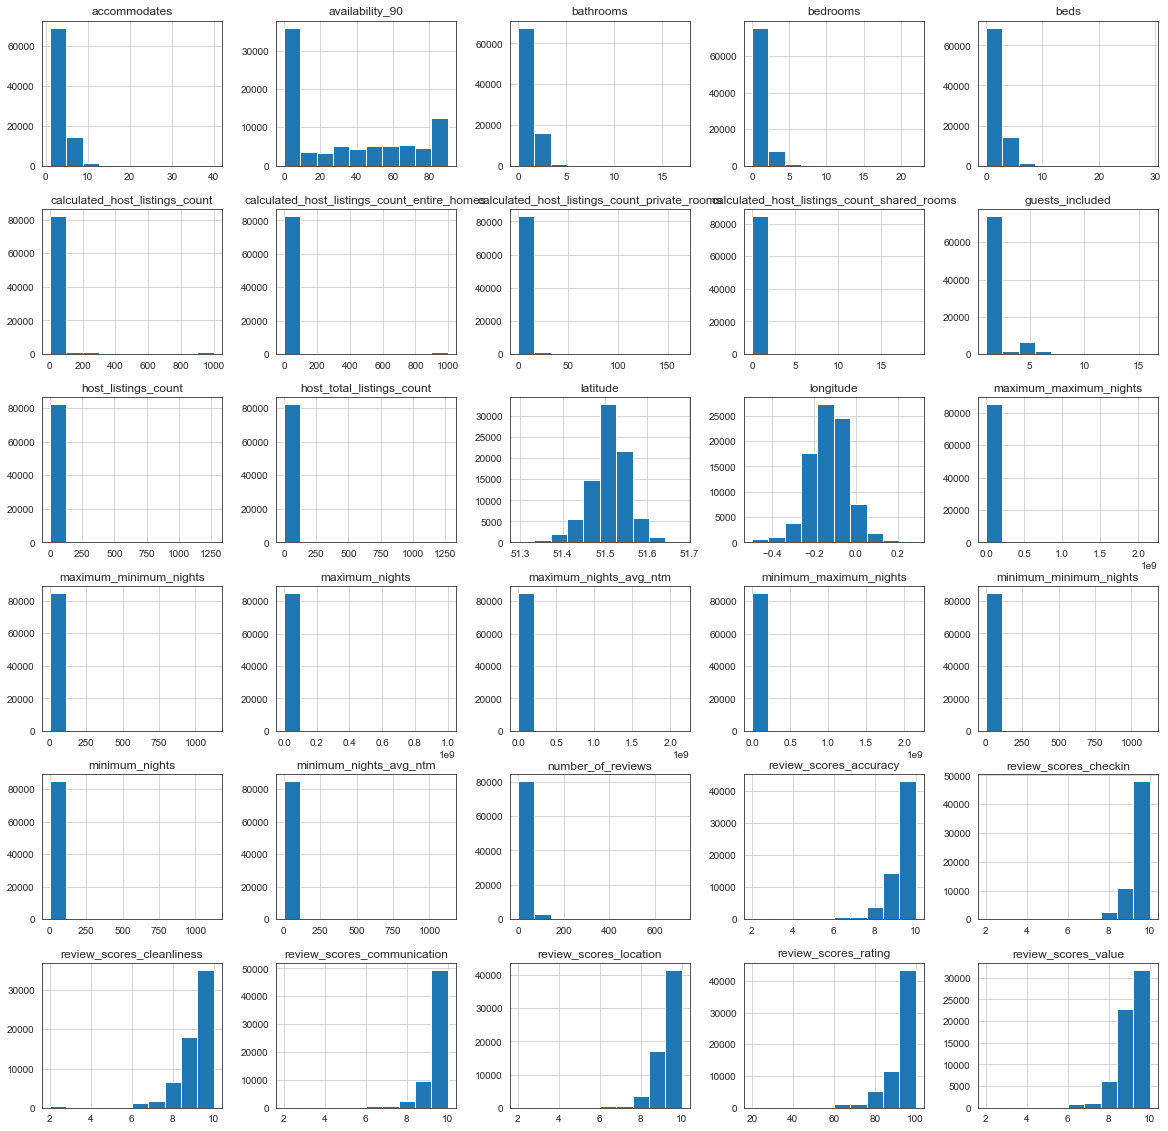

In [33]:
df.hist(figsize=(20,20))
plt.show()

In [34]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license', 'bed_type'], axis=1, inplace=True)

### Dropping multiple columns that describe host listings count, leaving only host_listings_count

In [35]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

### Dropping columns describing location, leaving only neighbourhood_cleansed that contains district name

In [36]:
df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

### Dropping columns describing max/min/avr of minimum/maximum number of nights guest has to spend, leaving only minimum_nights and maximum_nigths

In [37]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

### Checking which columns need to be cleaned

In [38]:
df.loc[:, df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

security_deposit               29123
host_response_rate             25897
host_response_time             25897
review_scores_checkin          21721
review_scores_value            21720
review_scores_location         21719
review_scores_accuracy         21673
review_scores_communication    21665
review_scores_cleanliness      21659
review_scores_rating           21620
cleaning_fee                   20995
beds                             149
bathrooms                        121
bedrooms                          89
host_identity_verified            12
host_listings_count               12
host_is_superhost                 12
host_since                        12
dtype: int64

### security_deposit

#### Replacing null values

In [39]:
df.security_deposit.fillna('$0.00', inplace=True)

#### Casting values to integer

In [40]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit = df.security_deposit.astype('int64')

### price

#### Looking at data

In [41]:
df['price'].sample(3)

id
37276257     $35.00
37422894     $90.00
38490145    $100.00
Name: price, dtype: object

#### Casting values to integer

In [42]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

#### Dropping most extreme values

In [43]:
df = df[df.price < np.percentile(df.price, 95)]
df = df[df.price > np.percentile(df.price, 5)]

### cleaning_fee

#### Replacing null values

In [44]:
df.cleaning_fee.fillna('$0.00', inplace=True)

#### Casting values to integer

In [45]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee = df.cleaning_fee.astype('int64')

### extra_people

#### Replacing null values

In [46]:
df.extra_people.fillna('$0.00', inplace=True)

#### Casting values to integer

In [47]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people = df.extra_people.astype('int64')

## Host_since

### Finding maximum value

In [48]:
df.sort_values('host_since', ascending=False).head(1)

,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy
id,,,,,,,,,,,,,,,,,,,,,
39866251,2019-11-04,NaN,NaN,f,1.0,t,Hammersmith and Fulham,Apartment,Private room,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible


### Setting time as host in days

In [49]:
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['days_as_host'] = (pd.datetime(2019, 11, 4) - pd.to_datetime(df.host_since)).dt.days
df.drop('host_since', axis=1, inplace=True)

df.days_as_host.fillna(df.days_as_host.median(), inplace=True)

## host_response_time

### Filling null values with unknown label

In [50]:
df.host_response_time.fillna("unknown", inplace=True)

## host_response_rate

### Removing percentage from string and casting it to float

In [51]:
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

### Grouping rates together

In [52]:
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

### Casting to string and replacing null values

In [53]:
df.host_response_rate = df.host_response_rate.astype('str')

df.host_response_rate.replace('nan', 'unknown', inplace=True)

### property_type

#### Looking at data

In [54]:
df.property_type.value_counts()

Apartment                 52328
House                     14694
Condominium                2760
Townhouse                  2553
Serviced apartment         1220
Loft                        698
Bed and breakfast           594
Guest suite                 355
Guesthouse                  290
Other                       169
Boutique hotel              159
Hotel                       142
Bungalow                    122
Cottage                      83
Hostel                       70
Tiny house                   65
Boat                         58
Aparthotel                   48
Houseboat                    31
Villa                        28
Cabin                        17
Camper/RV                    16
Earth house                  12
Chalet                       12
Hut                          10
Casa particular (Cuba)        7
Barn                          6
Farm stay                     5
Yurt                          5
Tent                          4
Dome house                    2
Campsite

#### Unifying property types

In [55]:
property_map = {
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'
}
df.property_type.replace(property_map, inplace=True)

#### Unifying other types into one group

In [56]:
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

### amenities

#### Creating columns for the most important amenities

In [57]:
df['self_check_in'] = df['amenities'].str.contains('Self check-in', case=False)
df['check_in_24h'] = df['amenities'].str.contains('24-hour check-in', case=False)

df['breakfast'] = df['amenities'].str.contains('Breakfast', case=False)
df['coffee_machine'] = df['amenities'].str.contains('Coffee maker|Espresso machine', case=False)
df['appliances'] = df['amenities'].str.contains('Cooking basics|Dishwasher|Dryer|Washer', case=False)

df['outdoor_space'] = df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace', case=False)

df['tv'] = df['amenities'].str.contains('TV|Television|Telly|TV Set', case=False)
df['internet'] = df['amenities'].str.contains('Internet|Pocket wifi|Wif', case=False)

#### Dropping column

In [58]:
df.drop('amenities', axis=1, inplace=True)

#### Filling null values with 0

In [59]:
amenities_cols = df.iloc[:,31:].columns
df[amenities_cols] = df[amenities_cols].fillna(0)

#### Calculating and dropping amenities that have little to no variance

In [60]:
infrequent_amenities = []
for col in df.iloc[:,31:].columns:
    if df[col].sum() < len(df) / 10:
        infrequent_amenities.append(col)

df.drop(infrequent_amenities, axis=1, inplace=True)

### cancellation_policy

#### Looking at data

In [61]:
df.cancellation_policy.value_counts(normalize = True)

strict_14_with_grace_period    0.427704
flexible                       0.321023
moderate                       0.243268
super_strict_60                0.004022
super_strict_30                0.003879
strict                         0.000104
Name: cancellation_policy, dtype: float64

#### Grouping policies into 3 main avalible on airbnb right now

In [62]:
cancellation_policy_map = {
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
}
df.cancellation_policy.replace(cancellation_policy_map, inplace=True)

## Overall

#### Dropping rows containing null values in important columns

In [63]:
df.dropna(subset=['beds'], inplace=True)
df.beds = df.beds.astype('float64')

df.dropna(subset=['bathrooms'], inplace=True)
df.bathrooms = df.bathrooms.astype('float64')

df.dropna(subset=['bedrooms'], inplace=True)
df.bedrooms = df.bedrooms.astype('float64')

df.dropna(subset=['host_listings_count'], inplace=True)
df.host_listings_count = df.host_listings_count.astype('float64')

#### Replacing f/t strings with value

In [64]:
string_boolean_map = {'f': 0, 't': 1}
df.replace(string_boolean_map, inplace=True)

#### Replacing booleans with value

In [65]:
boolean_map = {False: 0, True: 1}
df.replace(boolean_map, inplace=True)

## Data Visualization

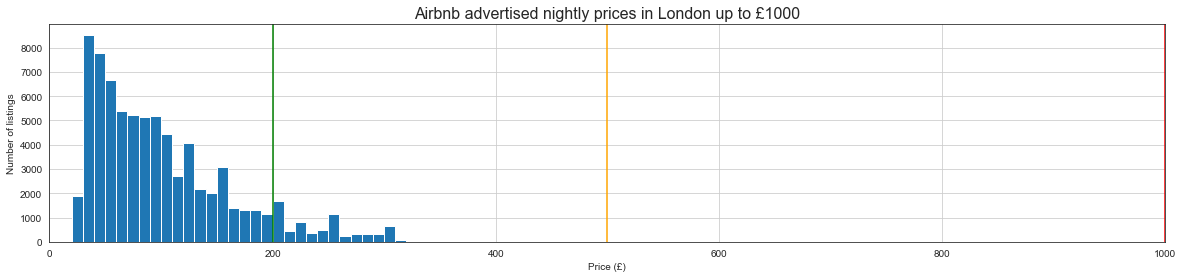

In [66]:
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='green')
plt.axvline(500, color='orange')
plt.axvline(1000, color='red')
plt.title("Airbnb advertised nightly prices in London up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

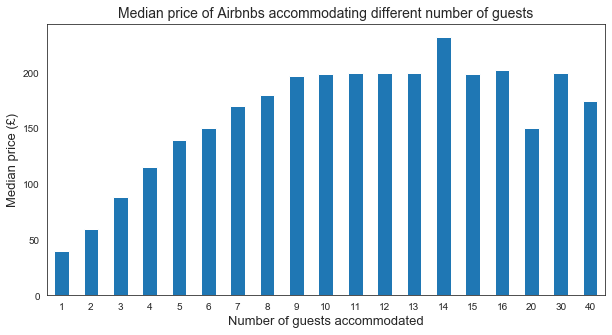

In [67]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.show()

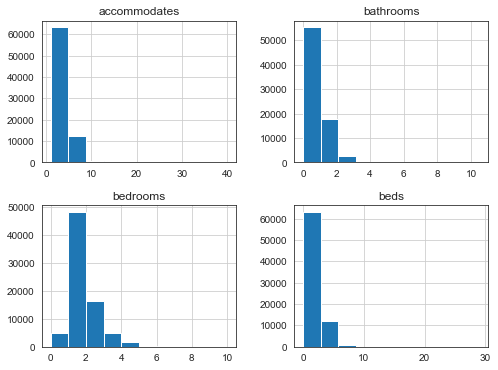

In [68]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

In [69]:
gdf.drop('neighbourhood_group', axis=1, inplace=True)
gdf.rename(columns={'neighbourhood' : 'neighborhood'}, inplace=True)
gdf = gdf.set_index('neighborhood')

In [70]:
def gen_map_chart(df, review_col, review_title):
    return alt.Chart(df, title=review_title).mark_geoshape().encode(color=f'{review_col}:Q', tooltip=['neighborhood:N', f'{review_col}:Q']).properties(width=250, height=250)

In [71]:
review_cols = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

listing_detail_cols = ['instant_bookable', 'neighbourhood_cleansed', 'room_type'] + review_cols

map_df = df[df.filter(regex='review_scores').notnull().all(axis=1)]
map_df.rename(columns={'neighbourhood_cleansed' : 'neighborhood'}, inplace=True)
map_df.set_index('neighborhood', inplace=True)

C:\Users\Thomas\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [72]:
geometry_df = gdf.loc[:, ['geometry']]
map_df = geometry_df.join(map_df)

In [73]:
map_df['mean_review_scores_accuracy'] = map_df.groupby('neighborhood')['review_scores_accuracy'].transform('mean')
map_df['mean_review_scores_cleanliness'] = map_df.groupby('neighborhood')['review_scores_cleanliness'].transform('mean')
map_df['mean_review_scores_checkin'] = map_df.groupby('neighborhood')['review_scores_checkin'].transform('mean')
map_df['mean_review_scores_communication'] = map_df.groupby('neighborhood')['review_scores_communication'].transform('mean')
map_df['mean_review_scores_location'] = map_df.groupby('neighborhood')['review_scores_location'].transform('mean')
map_df['mean_review_scores_value'] = map_df.groupby('neighborhood')['review_scores_value'].transform('mean')

map_df['mean_review_scores_all'] = map_df.filter(like='mean_review_scores').mean(axis=1)

In [74]:
map_df['number_of_listings'] = map_df.groupby('neighborhood').size()
median_price_by_neighborhood = map_df.groupby('neighborhood').price.median().values

In [75]:
map_df.reset_index(level=0, inplace=True)

In [76]:
review_cols = ['mean_review_scores_accuracy', 'mean_review_scores_cleanliness', 'mean_review_scores_checkin', 'mean_review_scores_communication', 'mean_review_scores_location', 'mean_review_scores_value']
review_titles = ['Accuracy', 'Cleanliness', 'Check-in', 'Communication', 'Location', 'Value']
review_map = {col: title for col, title in zip(review_cols, review_titles)}

result_df = map_df[['geometry', 'neighborhood', 'mean_review_scores_all', 'number_of_listings'] + review_cols].drop_duplicates()

In [77]:
result_df['median_price'] = median_price_by_neighborhood

In [78]:
review_charts = []

for review_col, review_title in zip(review_cols, review_titles):
    review_charts.append(gen_map_chart(result_df, review_col, review_title))

overall_map_chart = gen_map_chart(result_df, 'mean_review_scores_all', 'Overall')

((alt.vconcat(alt.concat(*review_charts, columns=3), overall_map_chart, 
              title='Average review scores by neighbourhood', 
              center=True)
     .configure_view(strokeWidth=0)
     .configure_title(fontSize=18)
     .configure_legend(title=None, orient='top',  labelFontSize=12)))

TypeError: data type not understood

alt.VConcatChart(...)

In [79]:
number_of_listings_map_chart = gen_map_chart(result_df, 'number_of_listings', 'Number of listings')

((number_of_listings_map_chart
     .configure_view(strokeWidth=0)
     .configure_title(fontSize=18)
     .configure_legend(title=None, orient='top',  labelFontSize=12)))

TypeError: data type not understood

alt.Chart(...)

In [80]:
price_map_chart = gen_map_chart(result_df, 'median_price', 'Price median')

((price_map_chart
     .configure_view(strokeWidth=0)
     .configure_title(fontSize=18)
     .configure_legend(title=None, orient='top',  labelFontSize=12)))

TypeError: data type not understood

alt.Chart(...)

## Modelling

### Replacing hightly correlated review columns with mean from all

In [81]:
review_cols = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

for col in review_cols:
    df[col].fillna(0, inplace=True)

df.review_scores_rating = df[review_cols].mean(axis=1)

df.drop(review_cols, axis=1, inplace=True)

In [82]:
df.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

In [83]:
transformed_df = pd.get_dummies(df)

In [84]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

In [85]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

In [86]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

### Scalling data

In [87]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

### Splittin data

In [88]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
stop

In [89]:
RESULTS_PATH = Path(r'C:\Users\Thomas\Desktop\PSI\AirbnbPrediction\results')

## LinearRegression

In [ ]:
param_grid = {
    'fit_intercept':[True,False], 
    'normalize':[True,False], 
    'copy_X':[True, False]
}

#training_scores_encoded = LabelEncoder().fit_transform(y_train)

grid_LinearRegression = GridSearchCV(LinearRegression(), param_grid, scoring='r2', cv=3, n_jobs=-1, return_train_score=True, verbose=1000)

grid_LinearRegression.fit(X_train, y_train)

In [ ]:
dump(grid_LinearRegression, 'LinearRegression.joblib')

In [90]:
grid_LinearRegression = load(RESULTS_PATH/'LinearRegression.joblib')

In [91]:
grid_LinearRegression.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [92]:
y_pred_train = grid_LinearRegression.predict(X_train)
y_pred_test = grid_LinearRegression.predict(X_test)

In [93]:
LinearRegression_results = pd.DataFrame({
    'algorithm':['LinearRegression'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
LinearRegression_results

,algorithm,training_r2_score,test_r2_score
0,LinearRegression,0.68065,0.677168


## Rigde

In [ ]:
param_grid = {'alpha':[0.1, 1, 10, 100, 200, 230, 250, 265, 270, 275, 290, 300, 500]}

grid_Ridge = GridSearchCV(Ridge(), param_grid, cv=3, scoring='r2', n_jobs=-1, return_train_score=True, verbose=1000)

grid_Ridge.fit(X_train, y_train)

In [ ]:
dump(grid_Ridge, 'Ridge.joblib')

In [95]:
grid_Ridge = load(RESULTS_PATH/'Ridge.joblib')

In [96]:
grid_Ridge.best_params_

{'alpha': 100}

In [97]:
y_pred_train = grid_Ridge.predict(X_train)
y_pred_test = grid_Ridge.predict(X_test)

In [98]:
Ridge_results = pd.DataFrame({
    'algorithm':['Ridge'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
Ridge_results

,algorithm,training_r2_score,test_r2_score
0,Ridge,0.680653,0.677196


## Lasso

In [ ]:
param_grid = {'alpha': [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]}

grid_Lasso = GridSearchCV(Lasso(), param_grid, scoring='r2', cv=3, n_jobs=-1, return_train_score=True, verbose=1000)

grid_Lasso.fit(X_train, y_train)

In [ ]:
dump(grid_Lasso, 'Lasso.joblib')

In [100]:
grid_Lasso = load(RESULTS_PATH/'Lasso.joblib')

In [101]:
grid_Lasso.best_params_

{'alpha': 0.0001}

In [102]:
y_pred_train = grid_Lasso.predict(X_train)
y_pred_test = grid_Lasso.predict(X_test)

In [103]:
Lasso_results = pd.DataFrame({
    'algorithm':['Lasso'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
Lasso_results

,algorithm,training_r2_score,test_r2_score
0,Lasso,0.68065,0.677191


## ElasticNet

In [ ]:
param_grid={"max_iter": [1, 5, 10],
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            "l1_ratio": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

grid_ElasticNet = GridSearchCV(ElasticNet(), param_grid, scoring='r2', cv=3, n_jobs=-1, return_train_score=True, verbose=1000)

grid_ElasticNet.fit(X_train, y_train)

In [ ]:
dump(grid_ElasticNet, 'ElasticNet.joblib')

In [105]:
grid_ElasticNet = load(RESULTS_PATH/'ElasticNet.joblib')

In [106]:
grid_ElasticNet.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.8, 'max_iter': 10}

In [107]:
y_pred_train = grid_ElasticNet.predict(X_train)
y_pred_test = grid_ElasticNet.predict(X_test)

In [108]:
ElasticNet_results = pd.DataFrame({
    'algorithm':['ElasticNet'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
ElasticNet_results

,algorithm,training_r2_score,test_r2_score
0,ElasticNet,0.680634,0.67721


## RandomForestRegressor

In [ ]:
param_grid={"n_estimators": [1, 5, 10, 20, 30, 40, 50, 100],
            "max_features": ["auto", "sqrt", "log2"],
            "min_samples_split": [2, 4, 8, 16],
            "bootstrap": [True, False],
}

grid_RandomForestRegressor = GridSearchCV(RandomForestRegressor(), param_grid, scoring='r2', cv=3, n_jobs=-1, return_train_score=True, verbose=1000)

grid_RandomForestRegressor.fit(X_train, y_train)

In [ ]:
dump(grid_RandomForestRegressor, 'RandomForestRegressor.joblib')

In [119]:
grid_RandomForestRegressor = load(RESULTS_PATH/'RandomForestRegressor.joblib')

In [120]:
grid_RandomForestRegressor.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 100}

In [121]:
y_pred_train = grid_RandomForestRegressor.predict(X_train)
y_pred_test = grid_RandomForestRegressor.predict(X_test)

In [122]:
RandomForestRegressor_results = pd.DataFrame({
    'algorithm':['RandomForestRegressor'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
RandomForestRegressor_results

,algorithm,training_r2_score,test_r2_score
0,RandomForestRegressor,0.99987,0.74558


## XGBRegressor

In [ ]:
XGBRegressor = xgboost.XGBRegressor()
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

grid_XGBRegressor = GridSearchCV(XGBRegressor, param_grid, scoring='r2', cv=3, n_jobs=-1, return_train_score=True, verbose=1000)

grid_XGBRegressor.fit(X_train, y_train)

In [ ]:
dump(grid_XGBRegressor, 'XGBRegressor.joblib')

In [124]:
grid_XGBRegressor = load(RESULTS_PATH/'XGBRegressor.joblib')

[22:38:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [125]:
grid_XGBRegressor.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 200}

In [126]:
y_pred_train = grid_XGBRegressor.predict(X_train)
y_pred_test = grid_XGBRegressor.predict(X_test)

In [127]:
XGBRegressor_results = pd.DataFrame({
    'algorithm':['XGBRegressor'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
XGBRegressor_results

,algorithm,training_r2_score,test_r2_score
0,XGBRegressor,0.799417,0.751305


## Initial deep neural networks

In [129]:
# Building the model
model_1 = Sequential()
model_1.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Compiling the model
model_1.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

In [131]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               9216      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 108,289
Trainable params: 108,289
Non-trainable params: 0
_________________________________________________________________


In [132]:
keras.utils.plot_model(model_1)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [ ]:
history_1 = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

In [ ]:
model_1.save(RESULTS_PATH/'model_1')
dump(history_1, RESULTS_PATH/'history_1.joblib')

In [133]:
model_1 = keras.models.load_model(RESULTS_PATH/'model_1')
history_1 = load(RESULTS_PATH/'history_1.joblib')

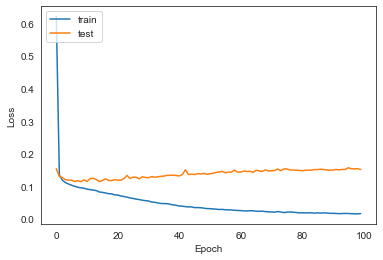

In [134]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [135]:
y_pred_train = model_1.predict(X_train)
y_pred_test = model_1.predict(X_test)

In [136]:
model_1_results = pd.DataFrame({
    'algorithm':['DNN'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
model_1_results

,algorithm,training_r2_score,test_r2_score
0,DNN,0.922924,0.583832


### Deep neural network with L1 regularization

In [138]:
model_2 = Sequential()
model_2.add(Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=l1(0.005), activation='relu'))
model_2.add(Dense(256, kernel_regularizer=l1(0.005), activation='relu'))
model_2.add(Dense(256, kernel_regularizer=l1(0.005), activation='relu'))
model_2.add(Dense(512, kernel_regularizer=l1(0.005), activation='relu'))
model_2.add(Dense(1, activation='linear'))

early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)

# Compiling the model
model_2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

In [140]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 128)               9216      
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_17 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 240,129
Trainable params: 240,129
Non-trainable params: 0
_________________________________________________________________


In [141]:
keras.utils.plot_model(model_2)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [ ]:
history_2 = model_2.fit(X_train,
                      y_train,
                      epochs=1000,
                      batch_size=256,
                      validation_split = 0.1,
                      callbacks=[early_stopping])

In [ ]:
model_2.save(RESULTS_PATH/'model_2')
dump(history_2, RESULTS_PATH/'history_2.joblib')

In [142]:
model_2 = keras.models.load_model(RESULTS_PATH/'model_2')
history_2 = load(RESULTS_PATH/'history_2.joblib')

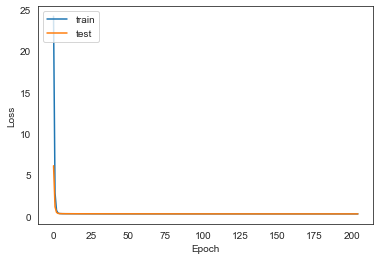

In [143]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [144]:
y_pred_train = model_2.predict(X_train)
y_pred_test = model_2.predict(X_test)

In [145]:
model_2_results = pd.DataFrame({
    'algorithm':['DNN with L1 regularization'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
model_2_results

,algorithm,training_r2_score,test_r2_score
0,DNN with L1 regularization,0.69175,0.689662


In [146]:
model_3 = Sequential()
model_3.add(Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=l1(0.005)))
model_3.add(BatchNormalization())
model_3.add(Activation("relu"))
model_3.add(Dropout(0.5))
model_3.add(Dense(256, kernel_regularizer=l1(0.005)))
model_3.add(BatchNormalization())
model_3.add(Activation("relu"))
model_3.add(Dropout(0.5))
model_3.add(Dense(256, kernel_regularizer=l1(0.005)))
model_3.add(BatchNormalization())
model_3.add(Activation("relu"))
model_3.add(Dropout(0.5))
model_3.add(Dense(512, kernel_regularizer=l1(0.005)))
model_3.add(BatchNormalization())
model_3.add(Activation("relu"))
model_3.add(Dropout(0.5))
model_3.add(Dense(1, activation='linear'))

early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)

# Compiling the model
model_3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

In [149]:
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 128)               9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)              

In [150]:
keras.utils.plot_model(model_3)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [ ]:
history_3 = model_3.fit(X_train,
                      y_train,
                      epochs=1000,
                      batch_size=256,
                      validation_split = 0.1,
                      callbacks=[early_stopping])

In [ ]:
model_3.save(RESULTS_PATH/'model_3')
dump(history_3, RESULTS_PATH/'history_3.joblib')

In [152]:
model_3 = keras.models.load_model(RESULTS_PATH/'model_3')
history_3 = load(RESULTS_PATH/'history_3.joblib')

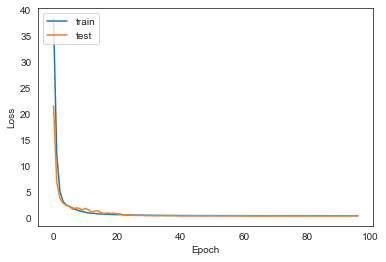

In [153]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [154]:
y_pred_train = model_3.predict(X_train)
y_pred_test = model_3.predict(X_test)

In [155]:
model_3_results = pd.DataFrame({
    'algorithm':['DNN with L1 regularization, batch normalization, dropout'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
model_3_results

,algorithm,training_r2_score,test_r2_score
0,"DNN with L1 regularization, batch normalizatio...",0.663151,0.658924


# Model comapision

In [165]:
models = [LinearRegression_results,
          Ridge_results,
          Lasso_results,
          ElasticNet_results,
          RandomForestRegressor_results,
          XGBRegressor_results,
          model_1_results,
          model_2_results,
          model_3_results]

models_df = [model.set_index('algorithm') for model in models]

pd.concat(models_df)

,training_r2_score,test_r2_score
algorithm,,
LinearRegression,0.680650,0.677168
Ridge,0.680653,0.677196
Lasso,0.680650,0.677191
ElasticNet,0.680634,0.677210
RandomForestRegressor,0.999870,0.745580
XGBRegressor,0.799417,0.751305
DNN,0.922924,0.583832
DNN with L1 regularization,0.691750,0.689662
"DNN with L1 regularization, batch normalization, dropout",0.663151,0.658924


# Categorical approach

In [166]:
print(df.price.min())
print(df.price.max())

26
314


In [167]:
transformed_df = df
transformed_df.price = pd.cut(transformed_df.price, bins=[0, 50, 100, 150, 200, 500], labels=['>50', '50-99', '100-149', '150-199', '>200'], include_lowest=True)

In [168]:
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

In [169]:
X = pd.get_dummies(X)

In [170]:
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(X.columns[X.columns.str.endswith('nan')]))

X.drop(to_drop, axis=1, inplace=True)

In [171]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [173]:
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y = encoder.transform(y_train)

In [174]:
dummy_y = keras.utils.to_categorical(encoded_y)

In [175]:
model_4 = Sequential()
model_4.add(Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=l1(0.005), activation='relu'))
model_4.add(Dense(256, kernel_regularizer=l1(0.005), activation='relu'))
model_4.add(Dense(256, kernel_regularizer=l1(0.005), activation='relu'))
model_4.add(Dense(512, kernel_regularizer=l1(0.005), activation='relu'))
model_4.add(Dense(dummy_y.shape[1], activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)
learn_control = ReduceLROnPlateau(monitor='val_categorical_accuracy', patience=3, verbose=1, factor=.5, min_lr=0.00000001)

model_4.compile(loss='categorical_crossentropy',
optimizer='adam',
                metrics=['categorical_accuracy'])

In [ ]:
history_4 = model_4.fit(X_train,
                        dummy_y,
                        epochs=1000,
                        batch_size=128,
                        validation_split = 0.25,
                        callbacks=[learn_control, early_stopping])

In [ ]:
model_4.save(RESULTS_PATH/'model_4')
dump(history_4, RESULTS_PATH/'history_4.joblib')

In [176]:
model_4 = keras.models.load_model(RESULTS_PATH/'model_4')
history_4 = load(RESULTS_PATH/'history_4.joblib')

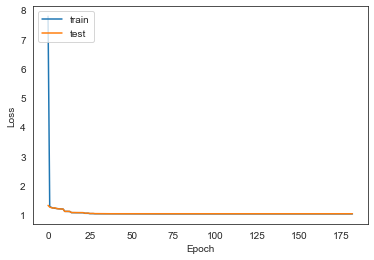

In [177]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

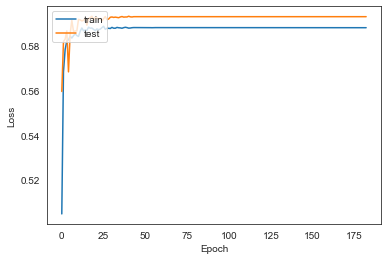

In [178]:
plt.plot(history_4.history['categorical_accuracy'])
plt.plot(history_4.history['val_categorical_accuracy'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Sentiment analysis and modeling of reviews

In [179]:
review_df = pd.merge(reviews_detail_df, listings_detail_df[['neighbourhood_group_cleansed', 'host_id', 'latitude','longitude', 'number_of_reviews', 'id', 'property_type']], 
              left_on='listing_id', right_on='id', how='left')

review_df.rename(columns = {'id_x':'id', 'neighbourhood_group_cleansed':'neighbourhood_group'}, inplace=True)
review_df.drop(['id_y'], axis=1, inplace=True)

In [181]:
from langdetect import detect

def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [ ]:
review_df['language'] = review_df['comments'].apply(language_detection)

In [ ]:
review_df.to_csv('processed_review_df', index=False)

In [191]:
review_df = pd.read_csv(RESULTS_PATH/'processed_review_df')

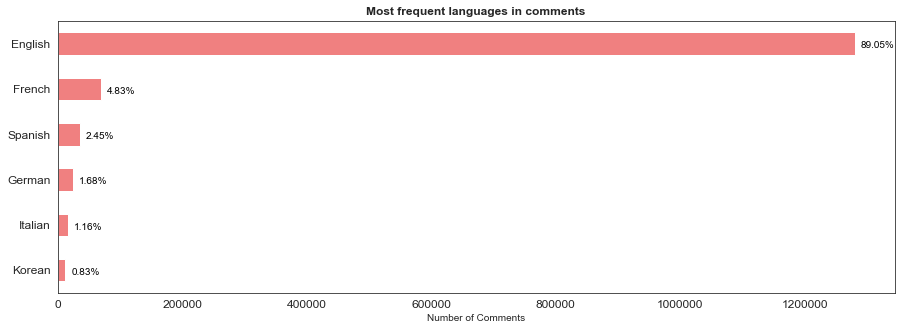

In [199]:
ax = review_df.language.value_counts().head(6).plot(kind='barh', figsize=(15,5), color="lightcoral", fontsize=12);

ax.set_title("Most frequent languages in comments", fontsize=12, fontweight='bold')
ax.set_xlabel("Number of Comments", fontsize=10)
ax.set_yticklabels(['English', 'French', 'Spanish', 'German', 'Italian', 'Korean'])

totals = []
for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax.patches:
    ax.text(x=i.get_width() + 10000, y=i.get_y()+.35, s=str(round((i.get_width()/total)*100, 2))+'%', fontsize=10, color='black')

ax.invert_yaxis()

## Splitting dataframe into language specific

In [200]:
review_df_eng = review_df[(review_df['language']=='en')]
review_df_de  = review_df[(review_df['language']=='de')]
review_df_fr  = review_df[(review_df['language']=='fr')]
review_df_es  = review_df[(review_df['language']=='es')]

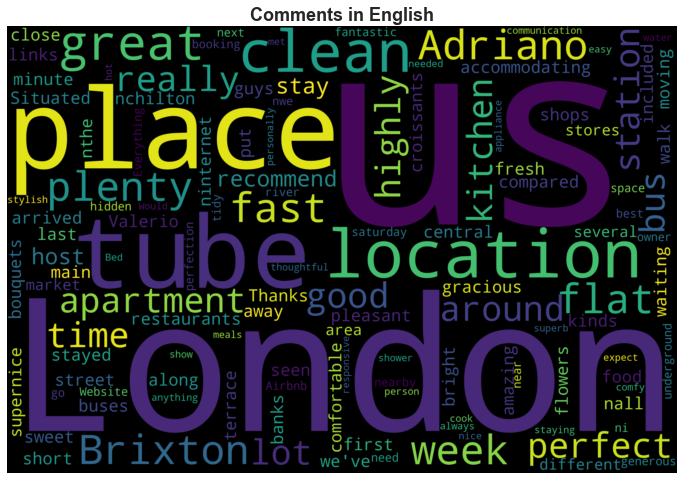

In [209]:
wordcloud = WordCloud(max_font_size=None, 
                      max_words=200, 
                      width=3000, 
                      height=2000,
                      stopwords=stopwords.words('english')).generate(str(review_df_eng.comments.values))

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Comments in English', fontsize=18, fontweight='bold')
plt.show()

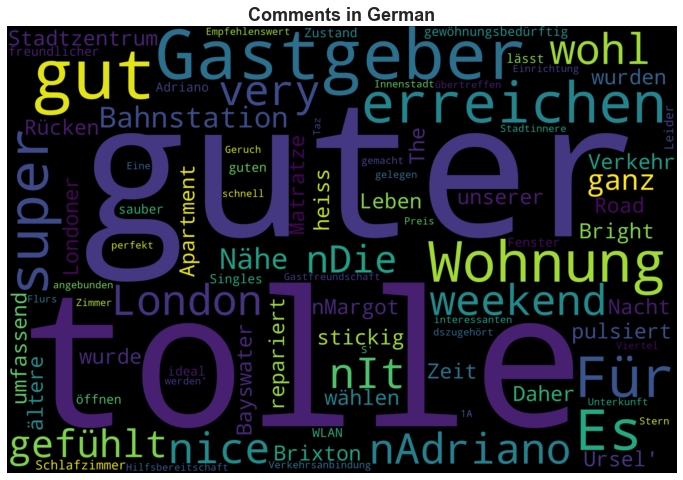

In [210]:
wordcloud = WordCloud(max_font_size=None, 
                      max_words=200, 
                      width=3000, 
                      height=2000,
                      stopwords=stopwords.words('german')).generate(str(review_df_de.comments.values))

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Comments in German', fontsize=18, fontweight='bold')
plt.show()

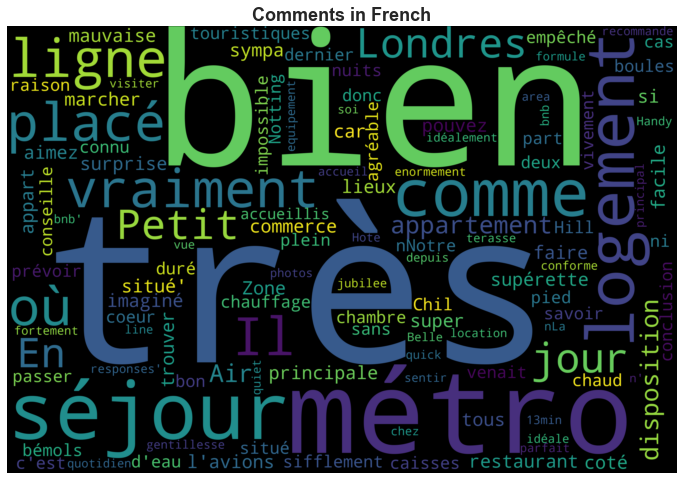

In [211]:
wordcloud = WordCloud(max_font_size=None, 
                      max_words=200, 
                      width=3000, 
                      height=2000,
                      stopwords=stopwords.words('french')).generate(str(review_df_fr.comments.values))

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Comments in French', fontsize=18, fontweight='bold')
plt.show()

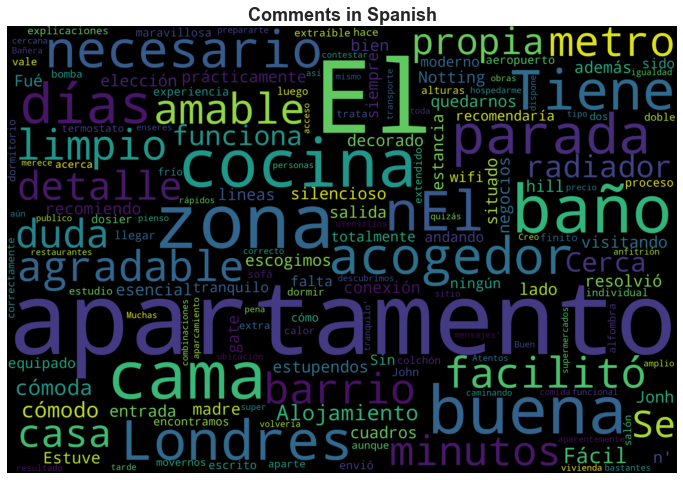

In [212]:
wordcloud = WordCloud(max_font_size=None, 
                      max_words=200, 
                      width=3000, 
                      height=2000,
                      stopwords=stopwords.words('spanish')).generate(str(review_df_es.comments.values))

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Comments in Spanish', fontsize=18, fontweight='bold')
plt.show()

In [216]:
analyzer = SentimentIntensityAnalyzer()

In [217]:
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

In [ ]:
review_df_eng['sentiment_neg'] = review_df_eng['comments'].apply(negative_score)
review_df_eng['sentiment_neu'] = review_df_eng['comments'].apply(neutral_score)
review_df_eng['sentiment_pos'] = review_df_eng['comments'].apply(positive_score)
review_df_eng['sentiment_compound'] = review_df_eng['comments'].apply(compound_score)

In [ ]:
review_df_eng.to_csv('review_df_eng', index=False)

In [218]:
review_df_eng = pd.read_csv(RESULTS_PATH/'review_df_eng')

Text(0.5, 0.98, 'Sentiment Analysis of Airbnb Reviews for London')

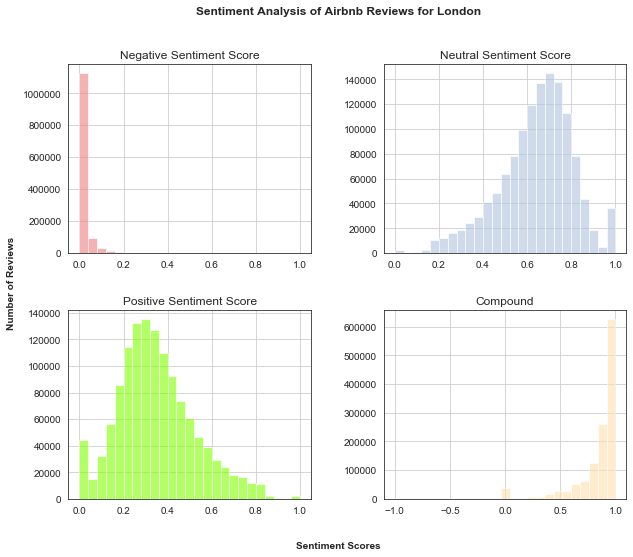

In [219]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))

review_df_eng.hist('sentiment_neg', bins=25, ax=axes[0,0], color='lightcoral', alpha=0.6)
axes[0,0].set_title('Negative Sentiment Score')
review_df_eng.hist('sentiment_neu', bins=25, ax=axes[0,1], color='lightsteelblue', alpha=0.6)
axes[0,1].set_title('Neutral Sentiment Score')
review_df_eng.hist('sentiment_pos', bins=25, ax=axes[1,0], color='chartreuse', alpha=0.6)
axes[1,0].set_title('Positive Sentiment Score')
review_df_eng.hist('sentiment_compound', bins=25, ax=axes[1,1], color='navajowhite', alpha=0.6)
axes[1,1].set_title('Compound')

fig.text(0.5, 0.04, 'Sentiment Scores',  fontweight='bold', ha='center')
fig.text(0.04, 0.5, 'Number of Reviews', fontweight='bold', va='center', rotation='vertical')

plt.suptitle('Sentiment Analysis of Airbnb Reviews for London', fontsize=12, fontweight='bold')

In [220]:
percentiles = review_df_eng.sentiment_compound.describe(percentiles=[.05, .1, .2, .3, .4, .5, .6, .7, .8, .9])

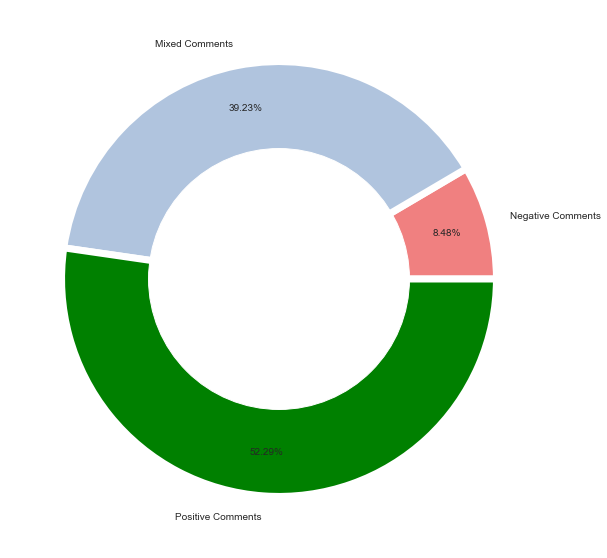

In [222]:
neg = percentiles['5%']
mid = percentiles['20%']
pos = percentiles['max']
names = ['Negative Comments', 'Mixed Comments', 'Positive Comments']
size = [neg, mid, pos]

plt.pie(size, 
        labels=names, 
        colors=['lightcoral', 'lightsteelblue', 'green'], 
        autopct='%.2f%%', 
        pctdistance=0.8,
        wedgeprops={'linewidth':7, 'edgecolor':'white' })

my_circle = plt.Circle((0,0), 0.6, color='white')

fig = plt.gcf()
fig.set_size_inches(10,10)
fig.gca().add_artist(my_circle)
plt.show()

In [223]:
review_df_eng_pos = review_df_eng.loc[review_df_eng.sentiment_compound >= 0.95]
review_eng_pos_comments = review_df_eng_pos['comments'].tolist()

review_df_eng_neg = review_df_eng.loc[review_df_eng.sentiment_compound < 0.0]
review_eng_neg_comments = review_df_eng_neg['comments'].tolist()

review_df_eng_pos['text_length'] = review_df_eng_pos['comments'].apply(len)
review_df_eng_neg['text_length'] = review_df_eng_neg['comments'].apply(len)

C:\Users\Thomas\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Thomas\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, 'Percentage of Comments')

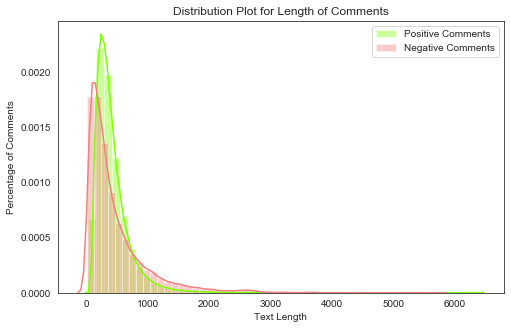

In [224]:
plt.figure(figsize=(8,5))

sns.distplot(review_df_eng_pos['text_length'], kde=True, bins=50, color='chartreuse')
sns.distplot(review_df_eng_neg['text_length'], kde=True, bins=50, color='lightcoral')

plt.title('Distribution Plot for Length of Comments')
plt.legend(['Positive Comments', 'Negative Comments'])
plt.xlabel('Text Length')
plt.ylabel('Percentage of Comments')

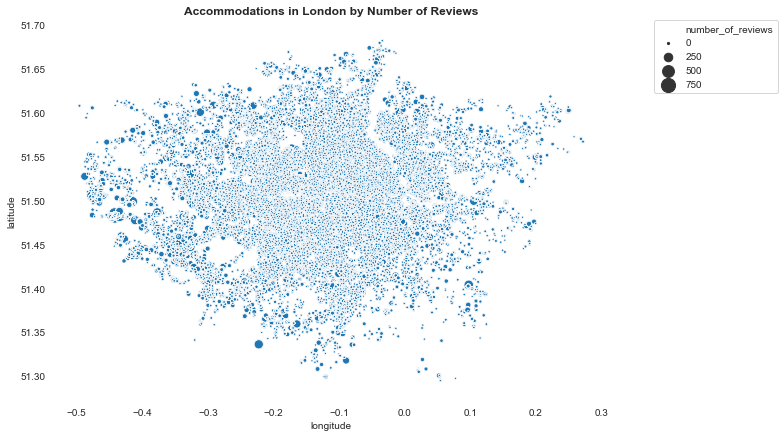

In [225]:
cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 7))

ax = sns.scatterplot(x="longitude", 
                     y="latitude", 
                     size='number_of_reviews', 
                     sizes=(5, 200), 
                     palette=cmap,  
                     data=review_df_eng)

ax.legend(bbox_to_anchor=(1.3, 1), borderaxespad=0.)
plt.title('Accommodations in London by Number of Reviews', fontsize=12, fontweight='bold')
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

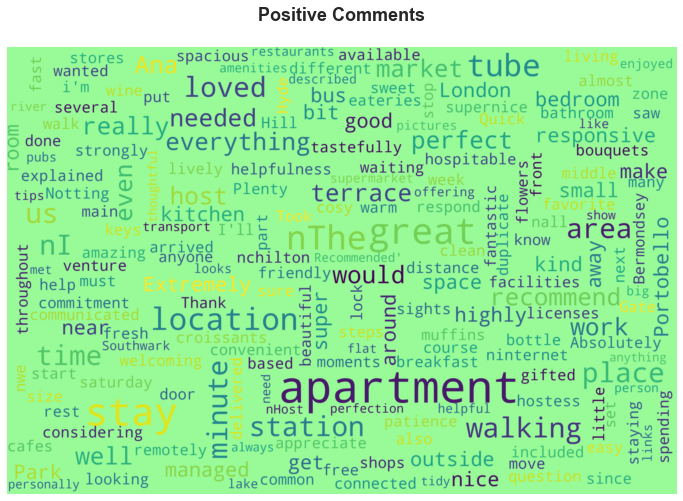

In [227]:
wordcloud = WordCloud(max_font_size=200, 
                      max_words=200, 
                      background_color="palegreen",
                      width= 3000, 
                      height = 2000,
                      stopwords = stopwords.words('english')).generate(str(review_df_eng_pos.comments.values))

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Positive Comments\n', fontsize=18, fontweight='bold')
plt.show()

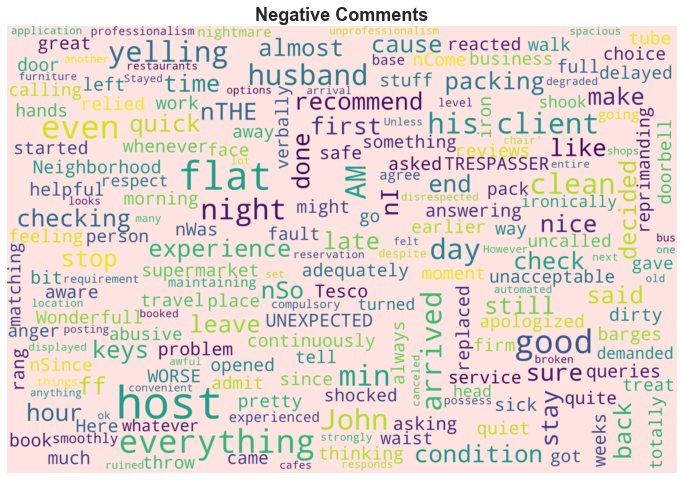

In [228]:
wordcloud = WordCloud(max_font_size=200, 
                      max_words=200, 
                      background_color="mistyrose",
                      width=3000, 
                      height=2000,
                      stopwords=stopwords.words('english')).generate(str(review_df_eng_neg.comments.values))

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Negative Comments', fontsize=18, fontweight='bold')
plt.show()